SVD truncated for space matrix:
http://scikit-learn.org/stable/modules/decomposition.html
FE ideas:
https://www.kaggle.com/visnaga/two-sigma-connect-rental-listing-inquiries/xgboost-for-the-millionth-time-0-54724-lb/code

In [1]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn,seaborn

2017-02-26 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1
seaborn 0.7.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.calibration import calibration_curve

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
   
class fe (BaseEstimator, TransformerMixin):
    """Custom tranformer that selects numerical featues (attribute names)
       and feature engineer to retunr attribute names plus new featues"""
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # selection
        X = X[self.attribute_names]
        # feature engineering
        X["bed_bath_ration"] = X["bedrooms"]/X["bathrooms"] # ratio rooms
        X["bed_bath_ration"] = X["bed_bath_ration"].map(lambda x: 100 if x>100 else x) # fix inf
        X["bed_bath_ration"].fillna(value=-1,inplace=True) # fix na
        
        X["room_dif"] = X["bedrooms"] - X["bathrooms"] 
        
        X["total_rooms"] = X["bedrooms"] + X["bathrooms"]  # total rooms
        
        X['half_bath'] = X['bathrooms'].map(lambda x: 1 if x%1 == 0.5 else 0) # halfbath
        
        X["number_features"] = X["features"].map(lambda x: len(x)) # total features
        
        X["number_photos"] = X["photos"].map(lambda x: len(x)) # total features
        
        X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
        
        X["ratio_rooms_photos"] = X["total_rooms"]/X["number_photos"]
        X["ratio_rooms_photos"] = X["ratio_rooms_photos"].map(lambda x: 100 if x>100 else x) # fix inf
        X["ratio_rooms_photos"].fillna(value=-1,inplace=True) # fix na
        
        X["price_per_room"] = X["price"]/X["total_rooms"]
        X["price_per_room"] = X["price_per_room"].map(lambda x: 100 if x>100 else x) # fix inf
        X["price_per_room"].fillna(value=-1,inplace=True) # fix na
        
        X["price_per_bedroom"] = X["price"]/X["bedrooms"]
        X["price_per_bedroom"] = X["price_per_bedroom"].map(lambda x: 100 if x>100 else x) # fix inf
        X["price_per_bedroom"].fillna(value=-1,inplace=True) # fix na
        
        X["price_per_bathroom"] = X["price"]/X["bathrooms"]
        X["price_per_bathroom"] = X["price_per_bathroom"].map(lambda x: 100 if x>100 else x) # fix inf
        X["price_per_bathroom"].fillna(value=-1,inplace=True) # fix na
       
        #duplicates
        X["photos_string"] = X.photos.map(lambda x: ' '.join(x))
        X["photos_duplicate"] = X.duplicated("photos_string",keep=False)
        X["features_string"] = X.photos.map(lambda x: ' '.join(x))
        X["features_duplicate"] = X.duplicated("features_string",keep=False)
        X["description_duplicate"] = X.duplicated("description",keep=False)
        
        # creation date
        X.created = pd.to_datetime(X.created)
        X["year"] = X["created"].dt.year
        X["day"] = X["created"].dt.day
        X["month"] = X["created"].dt.month
        X["hour"] = X["created"].dt.hour
        X["weekday"] = X["created"].dt.weekday
        X["days_passed"] = (X["created"].max() - X["created"]).dt.days
        
        
        # zones
        kmeans = KMeans(n_clusters=325, init='k-means++', n_init=10, max_iter=400,verbose=0, random_state=3, n_jobs=-1)
        kmeans.fit_transform(X[["longitude","latitude"]])
        X["kmeans"] =  kmeans.labels_
        
        # drop
        X.drop(["created","features","photos","photos_string","description","features_string"], axis=1, inplace=True)
        return X
    
class count_vector(BaseEstimator, TransformerMixin):
    """This custom tranformer select the features passes as the 
       argument attribute_names"""
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        vectorizer = CountVectorizer(min_df=1,stop_words='english')
        corpus = X[self.attribute_names].map(lambda x: ' '.join(x))
        cv = vectorizer.fit_transform(corpus)
        return cv
        
        
class tfidf_vector (BaseEstimator, TransformerMixin):
    """This custom tranformer select the features passes as the 
       argument attribute_names"""
    
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].apply(str)
        stemmer = SnowballStemmer("english",ignore_stopwords=True)
        X[self.key] = X[self.key].apply(stemmer.stem)

        tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')   
        tfidf_sparce = tfidf.fit_transform(X[self.key])
        return tfidf_sparce
             

        
class encode (BaseEstimator, TransformerMixin):
    """This custom tranformer select the features passes as the 
       argument attribute_names"""
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[self.attribute_names]
        
        encoder= LabelEncoder()
        
        X["building_id"] =  encoder.fit_transform(X["building_id"])
        X["manager_id"] =  encoder.fit_transform(X["manager_id"])
        X["display_address"] =  encoder.fit_transform(X["display_address"])
        X["street_address"] =  encoder.fit_transform(X["street_address"])
        
        X["photos"] = X.photos.map(lambda x: ' '.join(x))
        X["photos"] =  encoder.fit_transform(X["photos"])
       
        
        X["features"] = X.features.map(lambda x: ' '.join(x))
        X["features"] =  encoder.fit_transform(X["features"])
        
        
        X["description"] =  encoder.fit_transform(X["description"])
        
        
        return X       

In [4]:
#load data
train_df = pd.read_json("./input/train.json")
test_df = pd.read_json("./input/test.json")

#drop columns that won't be used 
train_df.drop(["listing_id"],axis=1, inplace=True)
y_test = test_df.listing_id.values
test_df.drop(["listing_id"],axis=1, inplace=True)

# encode target variable
encoder_interest = LabelEncoder()
y_train =  encoder_interest.fit_transform(train_df["interest_level"])
train_df.drop("interest_level", axis=1,inplace=True)

# feature categories
fe_features = ["bathrooms", "bedrooms", "latitude", "longitude",
               "price", "features", "created", "photos", "description"]
encode_features = ["building_id", "manager_id","display_address",
                   "photos", "features","description","street_address"]




# truncated SVD for sparce matrix features
tsvd_features = TruncatedSVD(n_components=40, random_state = 1)
tsvd_description = TruncatedSVD(n_components=20, random_state = 1)

#pipeline
rent_pipeline = Pipeline([
        ('union', FeatureUnion(
                transformer_list = [
                    ('fe',  fe(fe_features)),
                    ('encode',  encode(encode_features)),
                    ('listing_feat_to_sparce', Pipeline([('count_vectorizer', count_vector("features")),
                                                         ('tsvd_features', tsvd_features)
                                                        ])),
                    ('tfidf_description', Pipeline([('tfidf', tfidf_vector("description")),
                                                    ('tsvd_desc', tsvd_description)
                                                   ]))
                ],
                transformer_weights = {'fe':1.0,
                                       'encode':1.0,
                                       'listing_feat_to_sparce':1,
                                       'tfidf_description':1
                                      })
        )])


print(train_df.shape)
print(test_df.shape)

(49352, 13)
(74659, 13)


In [5]:
# run pipeline
rows_train = train_df.shape[0]
all_df = pd.concat([train_df,test_df])
X_all_df = pd.DataFrame(rent_pipeline.fit_transform(all_df))
X_train = X_all_df.iloc[:49352]
X_test = X_all_df.iloc[49352:]
print(X_train.shape)
print(X_test.shape)

(49352, 93)
(74659, 93)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 22.7min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 31.6min finished


 ----------------- GRID_SEARCH INFO -----------------
 
Best parameters:
{'n_estimators': 525, 'min_samples_leaf': 4, 'learning_rate': 0.1, 'max_features': 0.7}

Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=0.7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=525, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)

Best CV score: -0.564587261647

All scores:
[mean: -0.57470, std: 0.00388, params: {'n_estimators': 525, 'min_samples_leaf': 4, 'learning_rate': 0.1, 'max_features': 'sqrt'}, mean: -0.56459, std: 0.00423, params: {'n_estimators': 525, 'min_samples_leaf': 4, 'learning_rate': 0.1, 'max_features': 0.7}]


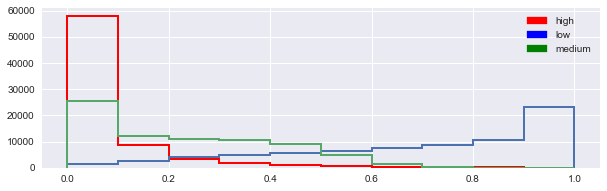

In [6]:
# model GB -gridsearch
param_grid = [{'n_estimators': [525], 'max_features': ['sqrt',0.7],
               'learning_rate': [0.1], 'min_samples_leaf':[4]}]

gbc = GradientBoostingClassifier(random_state=3)
grid_search = GridSearchCV(gbc, param_grid, cv=5,
                           scoring='neg_log_loss',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print("Best parameters:")
print(grid_search.best_params_)
print("\nBest estimator:")
print(grid_search.best_estimator_)
print("\nBest CV score:", grid_search.best_score_)
print("\nAll scores:")
print(grid_search.grid_scores_)

# submission
final_model = grid_search.best_estimator_
# predictions
final_predictions = final_model.predict_proba(X_test)
# sub
pd.DataFrame({'listing_id':y_test,
              'high':final_predictions[:,0],
              'medium':final_predictions[:,2],
              'low': final_predictions[:,1]}).to_csv("./submissions/subgb1.csv",index=False)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(final_predictions[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='high')
green_patch = mpatches.Patch(color='blue', label='low')
blue_patch = mpatches.Patch(color='green', label='medium')
plt.legend(handles=[pink_patch,green_patch,blue_patch])
plt.show()

In [ ]:
eclf = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('gbc', gbc), ('xgb',xgb)], voting='soft')
eclf.fit(X_train, y_train)
y_val_pred = eclf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

In [ ]:
param_grid = [{'n_estimators': [500], 'max_features': ['sqrt'],
               'bootstrap': [True], 'min_samples_leaf':[5]}]

forest_clas = RandomForestClassifier(random_state=3)
grid_search = GridSearchCV(forest_clas, param_grid, cv=5,
                           scoring='neg_log_loss',
                           n_jobs=-1,
                           verbose=3)

grid_search.fit(X_train, y_train)

print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("Best CV score:", grid_search.best_score_)
print(grid_search.grid_scores_)
               
# test set
#X_test = rent_pipeline.fit_transform(test_df)
# submission
final_model = grid_search.best_estimator_
# predictions
final_predictions = final_model.predict_proba(X_test)
# sub
pd.DataFrame({'listing_id':test_df.listing_id.values,
              'high':final_predictions[:,0],
              'medium':final_predictions[:,2],
              'low': final_predictions[:,1]}).to_csv("./submissions/subrf.csv",index=False)

# plot probs
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(final_predictions[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
# legend
import matplotlib.patches as mpatches
pink_patch = mpatches.Patch(color='red', label='high')
green_patch = mpatches.Patch(color='blue', label='low')
blue_patch = mpatches.Patch(color='green', label='medium')
plt.legend(handles=[pink_patch,green_patch,blue_patch])
plt.show()

In [ ]:
# feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)

# plot 15 most important features 
plt.figure(figsize=(8, 15))
plt.barh(range(len(fimpotances)), feature_importances[indices], color="r", align="center")
plt.yticks(range(len(fimpotances)), [x[1] for x in fimpotances])
plt.title("Feature importances", size=20)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# test set
X_test = rent_pipeline.fit_transform(test_df)
# submission
final_model = grid_search.best_estimator_
# predictions
final_predictions = final_model.predict_proba(X_test)
# sub
pd.DataFrame({'listing_id':test_df.listing_id.values,
              'high':final_predictions[:,0],
              'medium':final_predictions[:,2],
              'low': final_predictions[:,1]}).to_csv("./submissions/sub.csv",index=False)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

train_df = pd.read_json("./input/train.json")

west, south, east, north = -74.05, 40.60, -73.80, 40.90


fig = plt.figure(figsize=(22,27))

kmeans = KMeans(n_clusters=500, init='k-means++', n_init=10, max_iter=300,verbose=0, random_state=3, n_jobs=-1)
kmeans.fit_transform(train_df[["longitude","latitude"]])
train_df["kmeans"] =  kmeans.labels_

fig.add_subplot(222)

colors = cm.rainbow(np.linspace(0, 1, 500))

m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='i')

c=0
for k in train_df["kmeans"].unique():
    
    aa = train_df[train_df["kmeans"] == k]
    m.plot(aa['longitude'].values,aa['latitude'].values,
       'bo', 
       markersize=2, color=colors[c],alpha=0.3,
       markeredgewidth=0.05) 
    c=c+1

m.drawmapboundary(fill_color='black')

plt.show()

In [ ]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(final_predictions[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(final_model, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(final_model, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)


plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(final_predictions[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(final_predictions[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(final_predictions[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.set_ylim([0,65000])
plt.title("Normal")
plt.show()


plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(prob_pos_sigmoid[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(prob_pos_sigmoid[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(prob_pos_sigmoid[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.set_ylim([0,65000])
plt.title("Sigmoid")
plt.show()


plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (2, 0))
ax1.hist(prob_pos_isotonic[:,0], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2, color="red")
ax1.hist(prob_pos_isotonic[:,1], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.hist(prob_pos_isotonic[:,2], range=(0, 1), bins=10, label="tst",
             histtype="step", lw=2)
ax1.set_ylim([0,65000])
plt.title("Isitonic")
plt.show()

pd.DataFrame({'listing_id':test_df.listing_id.values,
              'high':prob_pos_sigmoid[:,0],
              'medium':prob_pos_sigmoid[:,2],
              'low': prob_pos_sigmoid[:,1]}).to_csv("./submissions/prob_pos_sigmoid.csv",index=False)
pd.DataFrame({'listing_id':test_df.listing_id.values,
              'high':prob_pos_sigmoid[:,0],
              'medium':prob_pos_sigmoid[:,2],
              'low': prob_pos_isotonic[:,1]}).to_csv("./submissions/prob_pos_isotonic.csv",index=False)

In [ ]:
X_train

tsvd_features = TruncatedSVD(n_components=40, random_state = 1)

tsvd_description = TruncatedSVD(n_components=20, random_state = 1)

Best parameters:
{'n_estimators': 525, 'min_samples_leaf': 4, 'learning_rate': 0.1, 'max_features': 0.7}

Best estimator:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=0.7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=525, presort='auto', random_state=3,
              subsample=1.0, verbose=0, warm_start=False)

Best CV score: -0.564587261647 - LB:0.56973